In [154]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

import keijzer_exogan as ke

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from glob import glob

from sklearn.metrics import r2_score
from scipy import stats

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab

# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks') 

# load inpainting data from the inpainting notebook(s)

In [155]:
# debug_0_5000_1_1e-1_c , Same inpainting settings as ExoGAN

general_name = 'debug_0_1000_1e-1_1_wgan_simple' # general filename, e.g. 'test' for test_reals.npy, test_inpainteds.npy... etc.

# get the file paths of the result files
reals = glob('gan_data//val_errors//'+general_name+'_reals.npy')
inpainteds = glob('gan_data//val_errors//'+general_name+'_inpainteds.npy')
n_iterations = glob('gan_data//val_errors//'+general_name+'_n_iterations.npy')


contextuals = glob('gan_data//val_errors//'+general_name+'_contextual_losses.npy')
perceptuals = glob('gan_data//val_errors//'+general_name+'_perceptual_losses.npy')

reals

['gan_data//val_errors//debug_0_1000_1e-1_1_wgan_simple_reals.npy']

In [156]:
# load arrays to list, convert list to ndarray with shape (aspa, n_inpaintings, height, width)
reals = np.concatenate([np.load(path) for path in reals], axis=0)
inpainteds = np.concatenate([np.load(path) for path in inpainteds], axis=0)

perceptuals = np.concatenate([np.load(path) for path in perceptuals], axis=0)
contextuals = np.concatenate([np.load(path) for path in contextuals], axis=0)

# take mean of the n_inpaintings per aspa
n_aspas = reals.shape[0]
reals = reals.mean(axis=1).reshape(n_aspas,1,32,32)
inpainteds = inpainteds.mean(axis=1).reshape(n_aspas,1,32,32)

In [157]:
reals.shape

(1000, 1, 32, 32)

In [158]:
reals.mean(1).shape

(1000, 32, 32)

# Error of ASPA $i$

In [159]:
"""
3739 is bad with errors: -20.025595	-59.902499	831.523538	-28.148670	22.250920	0.759872	-8.532101 (831% is CO)
4788 is good with errors: 4.121214	0.958426	0.045486	0.866588	-5.077431	-0.756804	2.978271
4998 is 'decent' with errors: 5.578141	7.753601	-6.975316	5.797133	39.391482	-1.526314	-41.867831
"""
i = 0 

decodeds =[ke.decode_params_from_aspa(inpainteds[i, j]) for j in range(reals.shape[1])]

df = pd.DataFrame.from_dict(decodeds)
df['perceptuals'] = pd.DataFrame(perceptuals)
df['contextuals'] = pd.DataFrame(contextuals)

df.describe()

,ch4_mixratio,co2_mixratio,co_mixratio,h2o_mixratio,planet_mass,planet_radius,temp_profile,perceptuals,contextuals
count,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000
mean,-7.910102,-5.219578,-2.707135,-4.887749,2.566080e+27,7.042008e+07,1989.309371,-0.074473,15.669934
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-7.910102,-5.219578,-2.707135,-4.887749,2.566080e+27,7.042008e+07,1989.309371,-0.074473,15.669934
25%,-7.910102,-5.219578,-2.707135,-4.887749,2.566080e+27,7.042008e+07,1989.309371,-0.074473,15.669934
50%,-7.910102,-5.219578,-2.707135,-4.887749,2.566080e+27,7.042008e+07,1989.309371,-0.074473,15.669934
75%,-7.910102,-5.219578,-2.707135,-4.887749,2.566080e+27,7.042008e+07,1989.309371,-0.074473,15.669934
max,-7.910102,-5.219578,-2.707135,-4.887749,2.566080e+27,7.042008e+07,1989.309371,-0.074473,15.669934


In [160]:
df

,ch4_mixratio,co2_mixratio,co_mixratio,h2o_mixratio,planet_mass,planet_radius,temp_profile,perceptuals,contextuals
0,-7.910102,-5.219578,-2.707135,-4.887749,2.566080e+27,7.042008e+07,1989.309371,-0.074473,15.669934


In [161]:
if reals.shape[1] > 1 :
    params = ['planet_mass','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

    fontsize = 16
    plt.figure(figsize=((25,10)))
    for i,param in enumerate(params):
        plt.subplot(3,3,i+1)
        plt.title(param, fontsize=fontsize)
        plt.hist(df[param], bins=25)

        # plot mean and median line
        mu = df[param].mean()
        plt.axvline(x=mu,  color='black', linestyle='-.', alpha=0.9, label='mean')
        plt.axvline(x=df[param].median(),  color='black', linestyle='-', alpha=1, label='median')

        # plot std lines
        plt.axvline(x=mu-df[param].std(),  color='black', linestyle=':', alpha=1, label=r'$\sigma$')
        plt.axvline(x=mu+df[param].std(),  color='black', linestyle=':', alpha=1)

        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

        plt.xlabel('Percentage error [%]', fontsize=fontsize)
        plt.ylabel('Counts [-]', fontsize=fontsize)

        plt.legend(fontsize=fontsize)
        plt.grid()
        plt.tight_layout()

In [162]:
reals.shape

(1000, 1, 32, 32)

In [163]:
#reals = reals.mean(axis=1) # take the mean of n_inpaintings per aspa, new shape is (aspa, height, width)
#inpainteds = inpainteds.mean(axis=1)

#reals = reals.reshape(reals.shape[0]*reals.shape[1], 32,32)
#inpainteds = inpainteds.reshape(inpainteds.shape[0]*inpainteds.shape[1], 32,32)

#from scipy import stats
#df = df[(np.abs(stats.zscore(df)) < 1).all(axis=1)]

reals.shape

(1000, 1, 32, 32)

In [164]:
reals.shape

(1000, 1, 32, 32)

## Spectrum plot

In [165]:
real = reals[i][0]
inpainted = inpainteds[i][0]

real.shape, inpainted.shape

((32, 32), (32, 32))

In [166]:
real_spec = real[:16, :25].flatten()
inpainted_spec = inpainted[:16, :25].flatten()

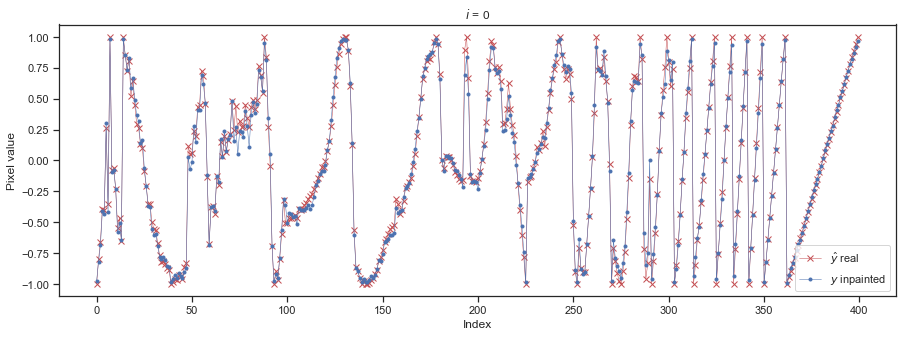

In [167]:
# :16, :25 is the spectrum location within the ASPA
plt.figure(figsize=(15,5))
plt.plot(real_spec, 'x-', c='r', linewidth=0.5, label=r'$\hat{y}$ real')
plt.plot(inpainted_spec, '.-', linewidth=0.5, label=r'$y$ inpainted')

plt.title(r'$i$ = %s' % i)
plt.xlabel('Index')
plt.ylabel('Pixel value')
plt.legend()

# Pixel difference plot

Text(0,0.5,'$y$-$\\hat{y}$')

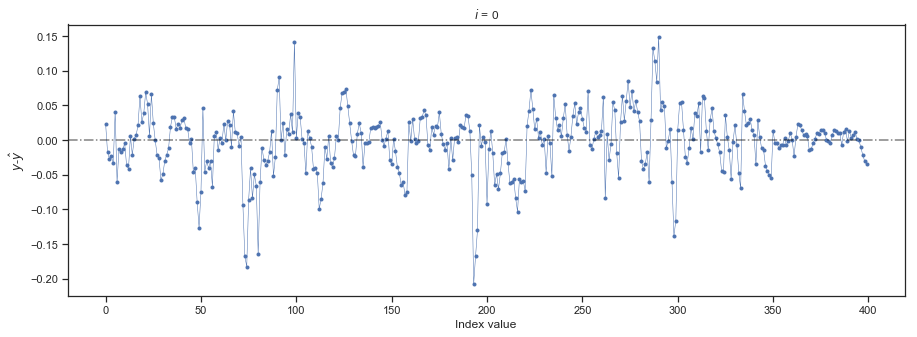

In [168]:
plt.figure(figsize=(15,5))

plt.plot(inpainted_spec - real_spec, '.-', linewidth=0.5)

plt.axhline(y=0,  color='black', linestyle='-.', alpha=0.5)

plt.title(r'$i$ = %s' % i)
plt.xlabel('Index value')
plt.ylabel(r'$y$-$\hat{y}$')

/home/16011015/notebooks/SRON-DCGAN/notebooks/keijzer_exogan.py:375: RuntimeWarning: Mean of empty slice.
  mins_ = [aspa[16:17, i*2:i*2+2].mean() for i in range(n_bins)]
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/16011015/notebooks/SRON-DCGAN/notebooks/keijzer_exogan.py:376: RuntimeWarning: Mean of empty slice.
  maxs_ = [aspa[17:18, i*2:i*2+2].mean() for i in range(n_bins)]
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


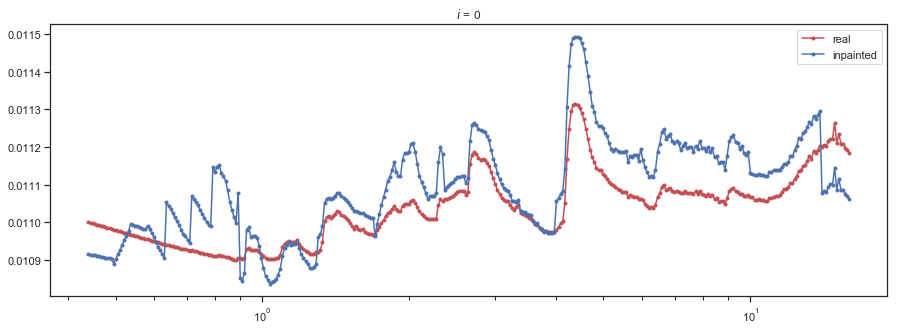

In [169]:
xhat,yhat = ke.decode_spectrum_from_aspa(real)
x,y  = ke.decode_spectrum_from_aspa(inpainted)

plt.figure(figsize=(15,5))
plt.plot(xhat, yhat, '.-', label='real', c='r')
plt.plot(x,y,'.-', label='inpainted')

plt.gca().set_xscale('log')

plt.title(r'$i$ = %s' % i)
plt.legend()

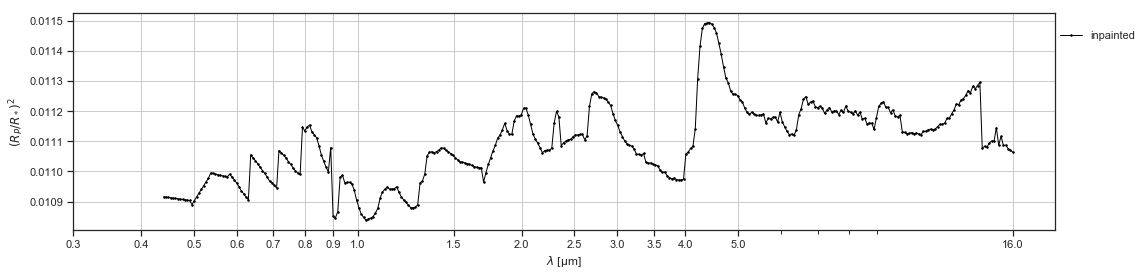

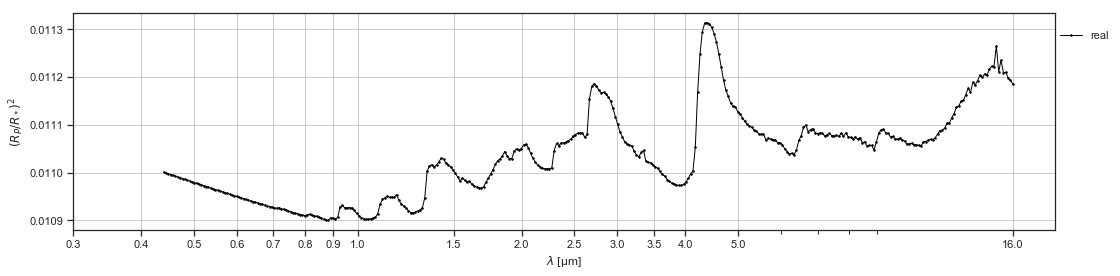

In [170]:
ke.plot_trans(x,y, label='inpainted')
ke.plot_trans(xhat,yhat, label='real')

# Error of all ASPAs

In [171]:
reals.shape

(1000, 1, 32, 32)

In [172]:
reals = [ke.decode_params_from_aspa(real[0]) for real in reals]
inpainteds = [ke.decode_params_from_aspa(inpainted[0]) for inpainted in inpainteds]

In [173]:
# create dfs for real, inpainted and their percentage errors

reals = pd.DataFrame.from_dict(reals)
inpainteds = pd.DataFrame.from_dict(inpainteds)
errors = (inpainteds - reals) / reals * 100

In [174]:
contextuals.shape

(1000,)

In [175]:
errors = errors.replace([np.inf, -np.inf], np.nan) # TODO: Fix the occurance of inf, this has to do with 0 Kelvin values

reals.columns = [column+'_real' for column in reals.columns]
inpainteds.columns = [column+'_inpainted' for column in inpainteds.columns]
errors.columns = [column+'_error' for column in errors.columns]

## Errors df

In [176]:
errors.describe()

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,11.279039,1.604164,12.245028,2.362941,10.218556,-0.373975,5.523170
std,51.247585,14.830750,80.508356,27.569236,44.474578,1.281853,32.727300
min,-72.844936,-58.391331,-84.255689,-67.443147,-59.396752,-6.397089,-49.968779
25%,-2.139081,-4.633391,-19.199189,-4.648119,-22.307885,-1.214096,-18.857088
50%,2.131337,0.022294,-0.250228,-0.882877,0.790349,-0.380526,1.828842
75%,9.787561,6.451598,17.479820,5.582893,32.656933,0.326334,26.282023
max,627.526233,141.295236,690.153188,692.938924,148.455146,3.897504,99.634689


In [177]:
errors[:10]

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
0,9.524489,6.764091,5.931356,-0.023310,12.665953,-2.521115,79.037844
1,-1.499082,-2.951409,6.833927,-3.919983,73.998938,-0.125582,11.161503
2,10.932259,-6.485596,-21.052059,19.419107,87.495502,0.422633,-23.218371
3,2.419785,8.017353,-16.068213,-4.666104,110.178937,0.212301,40.645210
4,-3.453423,-1.463597,87.637989,15.919214,-4.575773,0.112126,56.613237
5,-0.349486,-1.897409,1.312206,-3.351359,-48.418029,-1.911088,-35.050252
6,5.455164,12.570152,-5.376324,-1.676887,-41.281155,-1.492667,-21.737354
7,4.711267,29.342711,14.499205,1.600475,-35.201827,-2.511142,-26.905831
8,40.351474,9.014716,15.001011,-7.801052,-43.626075,-0.254344,14.686277
9,1.498690,-0.991667,-51.078703,-9.597194,1.009091,-0.502388,-14.090818


In [178]:
errors[(errors.co_mixratio_error < 0.1) & (errors.co_mixratio_error > -0.1)]

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
199,-0.372823,4.633518,0.053498,-1.271711,-15.514941,0.062345,31.220724
243,89.076597,-33.390915,0.073571,-1.945015,-16.749392,-4.187174,9.633312
553,0.061839,-1.261263,-0.085269,-3.461632,3.405803,-0.644335,-34.327416
982,-0.821752,-1.627718,-0.047487,2.794190,-38.358572,-1.010854,-39.188497


In [179]:
### join the dfs together
df = reals.join(inpainteds, how='outer')
df = df.join(errors, how='outer')

df['perceptuals'] = pd.DataFrame(perceptuals)
df['contextuals'] = pd.DataFrame(contextuals)

In [180]:
df.describe()

,ch4_mixratio_real,co2_mixratio_real,co_mixratio_real,h2o_mixratio_real,planet_mass_real,planet_radius_real,temp_profile_real,ch4_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted,...,temp_profile_inpainted,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error,perceptuals,contextuals
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-4.517889,-4.398889,-4.584778,-4.392667,2.651633e+27,8.009315e+07,1499.888889,-4.696384,-4.407375,-4.539011,...,1510.889007,11.279039,1.604164,12.245028,2.362941,10.218556,-0.373975,5.523170,-0.087310,15.099754
std,2.219000,2.206086,2.275672,2.230905,7.359836e+26,1.610428e+07,313.994284,2.185634,2.234891,2.336945,...,325.364842,51.247585,14.830750,80.508356,27.569236,44.474578,1.281853,32.727300,0.020819,18.182737
min,-8.000000,-8.000000,-8.000000,-8.000000,1.518400e+27,5.592880e+07,1000.000000,-7.998886,-7.946275,-7.968830,...,1000.046074,-72.844936,-58.391331,-84.255689,-67.443147,-59.396752,-6.397089,-49.968779,-0.153526,6.082681
25%,-6.444445,-6.444445,-6.444445,-6.444445,2.024533e+27,6.680384e+07,1222.222209,-6.519112,-6.455319,-6.889234,...,1220.966369,-2.139081,-4.633391,-19.199189,-4.648119,-22.307885,-1.214096,-18.857088,-0.100663,9.760463
50%,-4.888889,-4.111111,-4.888889,-4.111111,2.530667e+27,7.767889e+07,1444.444444,-4.936335,-4.257967,-4.566020,...,1523.697787,2.131337,0.022294,-0.250228,-0.882877,0.790349,-0.380526,1.828842,-0.085608,11.569800
75%,-2.555556,-2.555556,-2.555556,-2.555556,3.289867e+27,9.399146e+07,1777.777791,-2.661257,-2.380596,-2.308708,...,1815.532438,9.787561,6.451598,17.479820,5.582893,32.656933,0.326334,26.282023,-0.073069,13.834617
max,-1.000000,-1.000000,-1.000000,-1.000000,3.796000e+27,1.048665e+08,2000.000000,-1.116375,-1.068065,-1.007792,...,1999.825567,627.526233,141.295236,690.153188,692.938924,148.455146,3.897504,99.634689,-0.027704,183.344666


In [181]:
df[:10]

,ch4_mixratio_real,co2_mixratio_real,co_mixratio_real,h2o_mixratio_real,planet_mass_real,planet_radius_real,temp_profile_real,ch4_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted,...,temp_profile_inpainted,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error,perceptuals,contextuals
0,-7.222222,-4.888889,-2.555556,-4.888889,2.277600e+27,7.224137e+07,1111.111104,-7.910102,-5.219578,-2.707135,...,1989.309371,9.524489,6.764091,5.931356,-0.023310,12.665953,-2.521115,79.037844,-0.074473,15.669934
1,-4.111111,-3.333334,-7.222222,-4.888889,1.771467e+27,6.136632e+07,1777.777791,-4.049482,-3.234953,-7.715784,...,1976.204515,-1.499082,-2.951409,6.833927,-3.919983,73.998938,-0.125582,11.161503,-0.098114,10.259799
2,-1.777778,-1.777778,-3.333334,-1.000000,1.771467e+27,9.942898e+07,1444.444444,-1.972129,-1.662478,-2.631598,...,1109.067976,10.932259,-6.485596,-21.052059,19.419107,87.495502,0.422633,-23.218371,-0.086542,14.431634
3,-3.333334,-4.111111,-3.333334,-7.222222,1.518400e+27,6.136632e+07,1111.111104,-3.413993,-4.440714,-2.797726,...,1562.724546,2.419785,8.017353,-16.068213,-4.666104,110.178937,0.212301,40.645210,-0.104500,6.945427
4,-7.222222,-3.333334,-4.111111,-1.000000,3.289867e+27,5.592880e+07,1000.000000,-6.972809,-3.284547,-7.714007,...,1566.132367,-3.453423,-1.463597,87.637989,15.919214,-4.575773,0.112126,56.613237,-0.082081,6.892142
5,-4.888889,-8.000000,-7.222222,-6.444445,3.036800e+27,9.942898e+07,1666.666672,-4.871803,-7.848208,-7.316993,...,1082.495809,-0.349486,-1.897409,1.312206,-3.351359,-48.418029,-1.911088,-35.050252,-0.087417,17.730755
6,-7.222222,-1.000000,-6.444445,-4.888889,3.796000e+27,9.942898e+07,1333.333328,-7.616207,-1.125702,-6.097970,...,1043.501943,5.455164,12.570152,-5.376324,-1.676887,-41.281155,-1.492667,-21.737354,-0.076355,12.211500
7,-4.888889,-1.000000,-1.000000,-7.222222,3.796000e+27,7.224137e+07,1555.555556,-5.119218,-1.293427,-1.144992,...,1137.020409,4.711267,29.342711,14.499205,1.600475,-35.201827,-2.511142,-26.905831,-0.079356,10.162127
8,-1.000000,-4.888889,-1.000000,-6.444445,3.036800e+27,7.224137e+07,1666.666672,-1.403515,-5.329609,-1.150010,...,1911.437958,40.351474,9.014716,15.001011,-7.801052,-43.626075,-0.254344,14.686277,-0.092268,8.670661
9,-2.555556,-5.666667,-8.000000,-1.777778,3.542933e+27,6.680384e+07,1777.777791,-2.593856,-5.610472,-3.913704,...,1527.274350,1.498690,-0.991667,-51.078703,-9.597194,1.009091,-0.502388,-14.090818,-0.079763,11.025351


In [182]:
#df = df.drop(['temp_profile_error','temp_profile_real','temp_profile_inpainted'], axis=1)

# Percentage error histograms per retrieved parameter

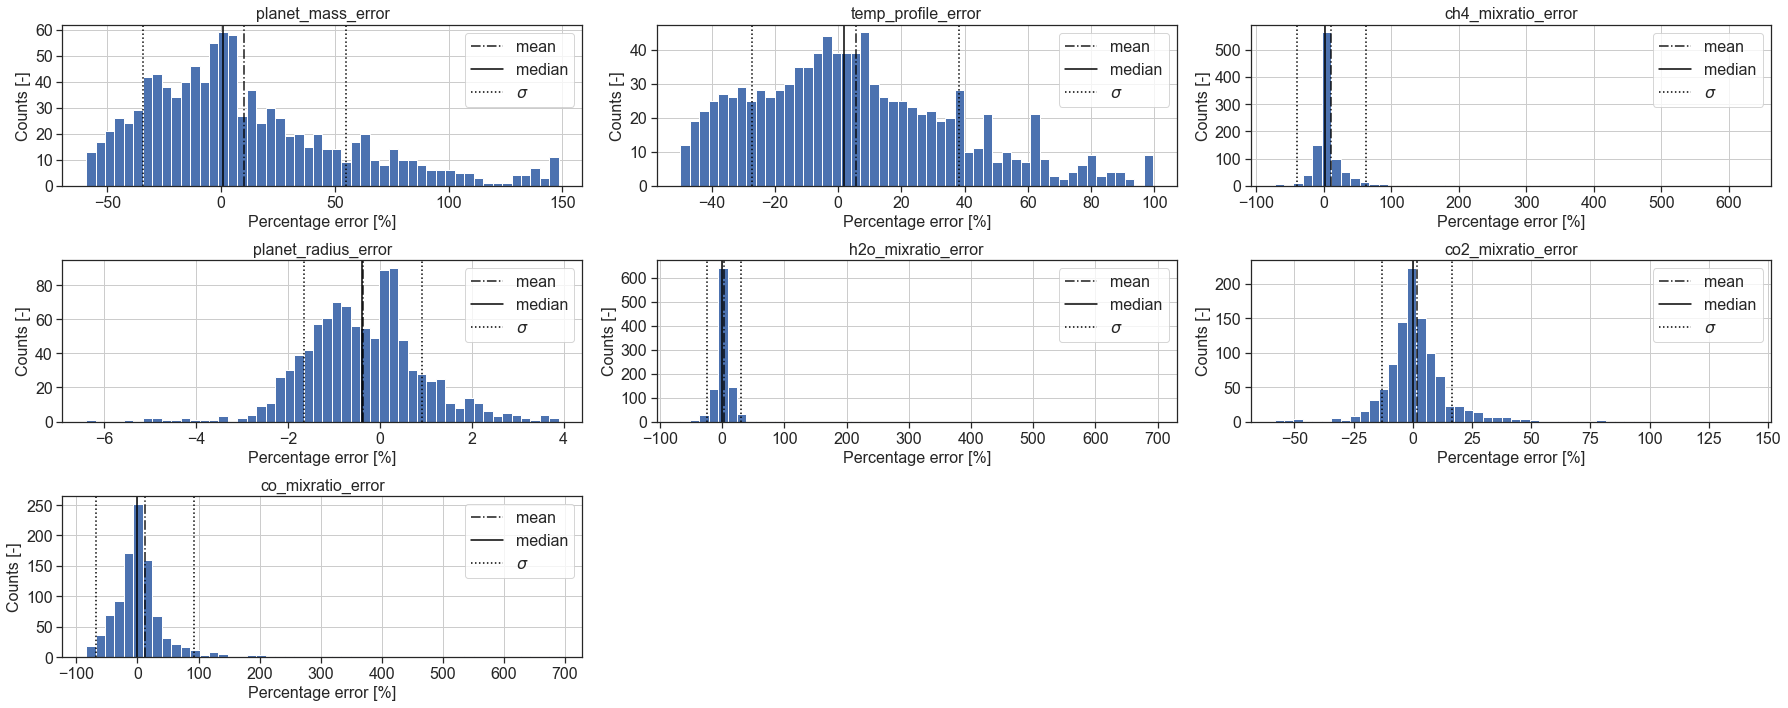

In [183]:
params = ['planet_mass','temp_profile','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']
#params = ['planet_mass','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

fontsize = 16
plt.figure(figsize=((25,10)))
for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.title(param+'_error', fontsize=fontsize)
    plt.hist(df[param+'_error'], bins=50)
    
    # plot mean and median line
    mu = df[param+'_error'].mean()
    plt.axvline(x=mu,  color='black', linestyle='-.', alpha=0.9, label='mean')
    plt.axvline(x=df[param+'_error'].median(),  color='black', linestyle='-', alpha=1, label='median')

    # plot std lines
    plt.axvline(x=mu-df[param+'_error'].std(),  color='black', linestyle=':', alpha=1, label=r'$\sigma$')
    plt.axvline(x=mu+df[param+'_error'].std(),  color='black', linestyle=':', alpha=1)
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.xlabel('Percentage error [%]', fontsize=fontsize)
    plt.ylabel('Counts [-]', fontsize=fontsize)
    
    plt.legend(fontsize=fontsize)
    plt.grid()
    plt.tight_layout()

# Grab the $n$ sigma errors

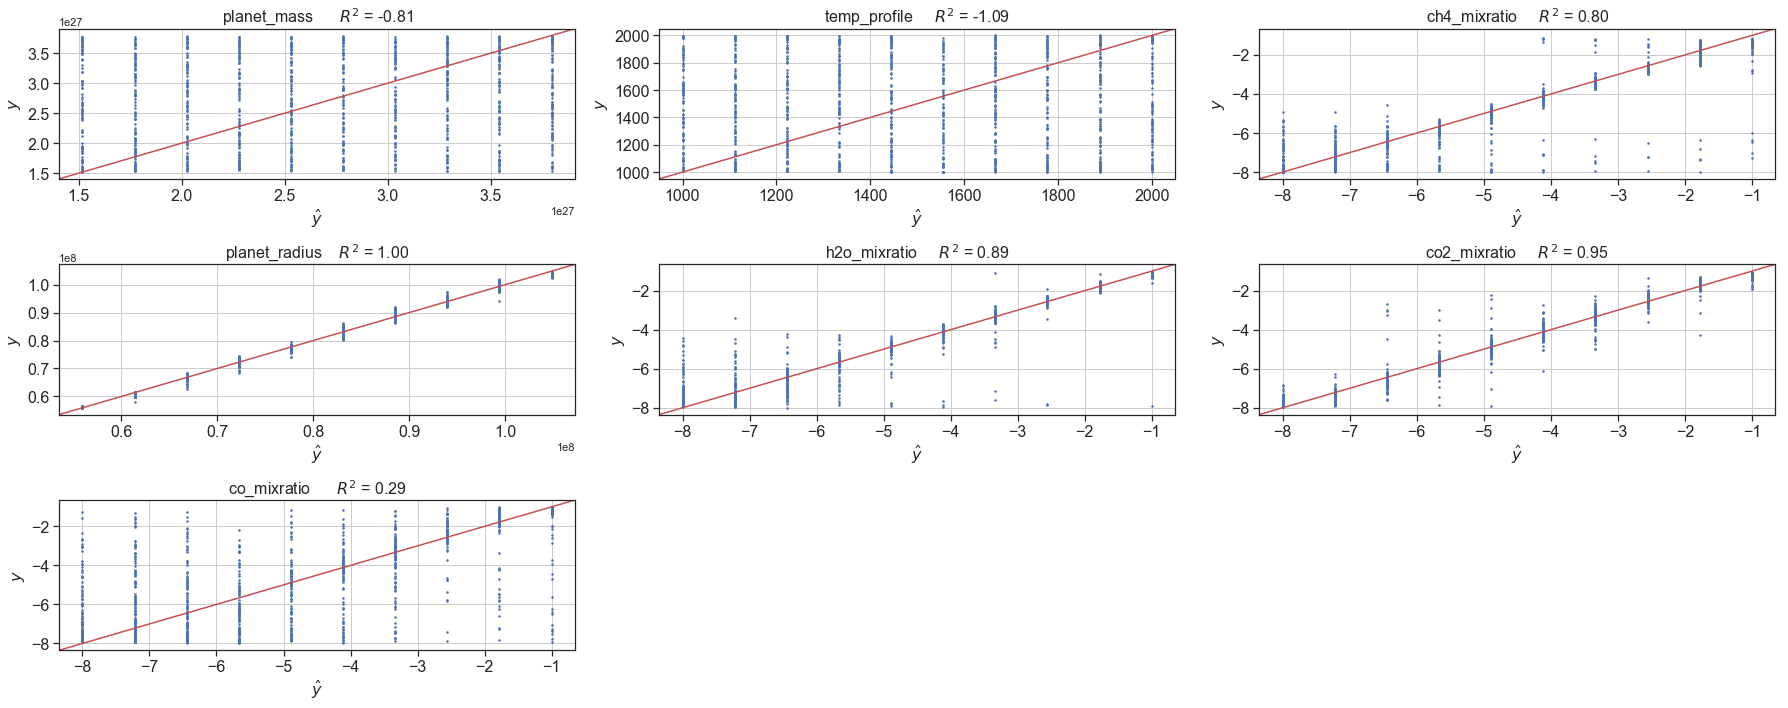

In [184]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    y_hat = df[param+'_real']
    y = df[param+'_inpainted']
    
    r2 = r2_score(y_hat, y)
    
    plt.subplot(3,3,i+1)

    plt.title(param +' \t $R^2$ = %.2f' % r2, fontsize=fontsize)
    plt.plot(y_hat, y, '.', ms=3)
    
    """Force x,y range on the same scale outliers outside of range wont be plotted!"""
    x_min, x_max = plt.xlim()
    x_min = x_min*1
    x_max = x_max*1
    
    plt.ylim((x_min, x_max)) # set y axis range the same as x axis range
    plt.xlim((x_min, x_max))
    
    # Plot the red 'perfect' prediction line
    plt.plot(plt.xlim(), plt.ylim(), ls="-", c='r')
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.xlabel(r"$\hat{y}$", fontsize=fontsize)
    plt.ylabel(r"$y$", fontsize=fontsize)
    plt.grid()
    plt.tight_layout()

# 1$\sigma$ percentage error per parameter

### Unique values STD plot
y axis, STD  
X axis, unique values  

This plot shows the STD per parameter value (10 values for ExoGAN data)

Horizontal -. line is the 10% line

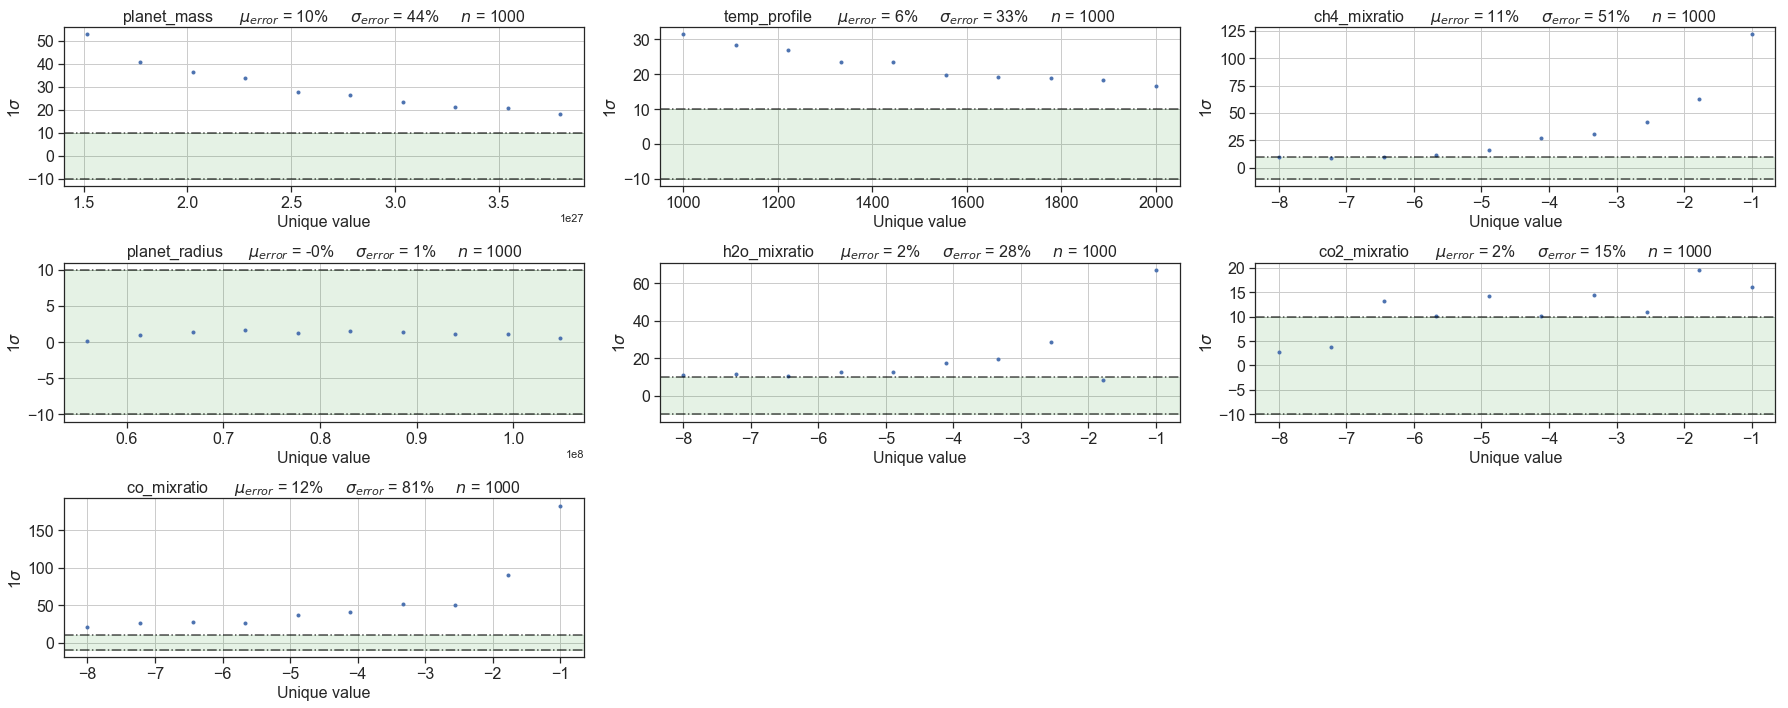

In [185]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    uniques = df[param+'_real'].unique()
    
    counts = []
    stds = []
    for unique in uniques:
        t = df[param+'_error'][(df[param+'_real'] == unique)]
        std = t.std()
        count = t.count()
        #print(count, std)

        counts.append(count)
        stds.append(std)

    plt.subplot(3,3,i+1)
    plt.plot(uniques, stds, '.')
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Unique value', fontsize=fontsize)
    plt.ylabel(r'1$\sigma$', fontsize=fontsize)
    plt.tight_layout()
    

In [186]:
iters = [np.load(iters) for iters in n_iterations]
iters

[array([], dtype=float64)]

In [187]:
uniques

array([-2.55555567, -7.22222248, -3.33333351, -4.11111126, -6.44444475,
       -1.        , -8.00000042, -5.66666691, -1.77777794, -4.88888907])

# Losses

In [188]:
df[['perceptuals', 'contextuals']].describe()

,perceptuals,contextuals
count,1000.000000,1000.000000
mean,-0.087310,15.099754
std,0.020819,18.182737
min,-0.153526,6.082681
25%,-0.100663,9.760463
50%,-0.085608,11.569800
75%,-0.073069,13.834617
max,-0.027704,183.344666


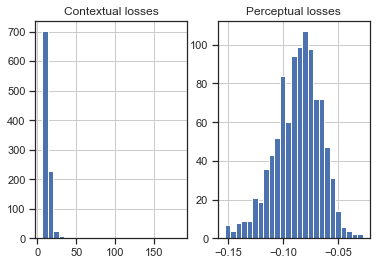

In [189]:
plt.subplot(1,2,1)
plt.hist(df.contextuals, bins=25)
plt.title('Contextual losses')
plt.grid()

plt.subplot(1,2,2)
plt.hist(df.perceptuals, bins=25)
plt.title('Perceptual losses')
plt.grid()

# Param percentage errors vs contextual loss
For contextual loss, lower is better.

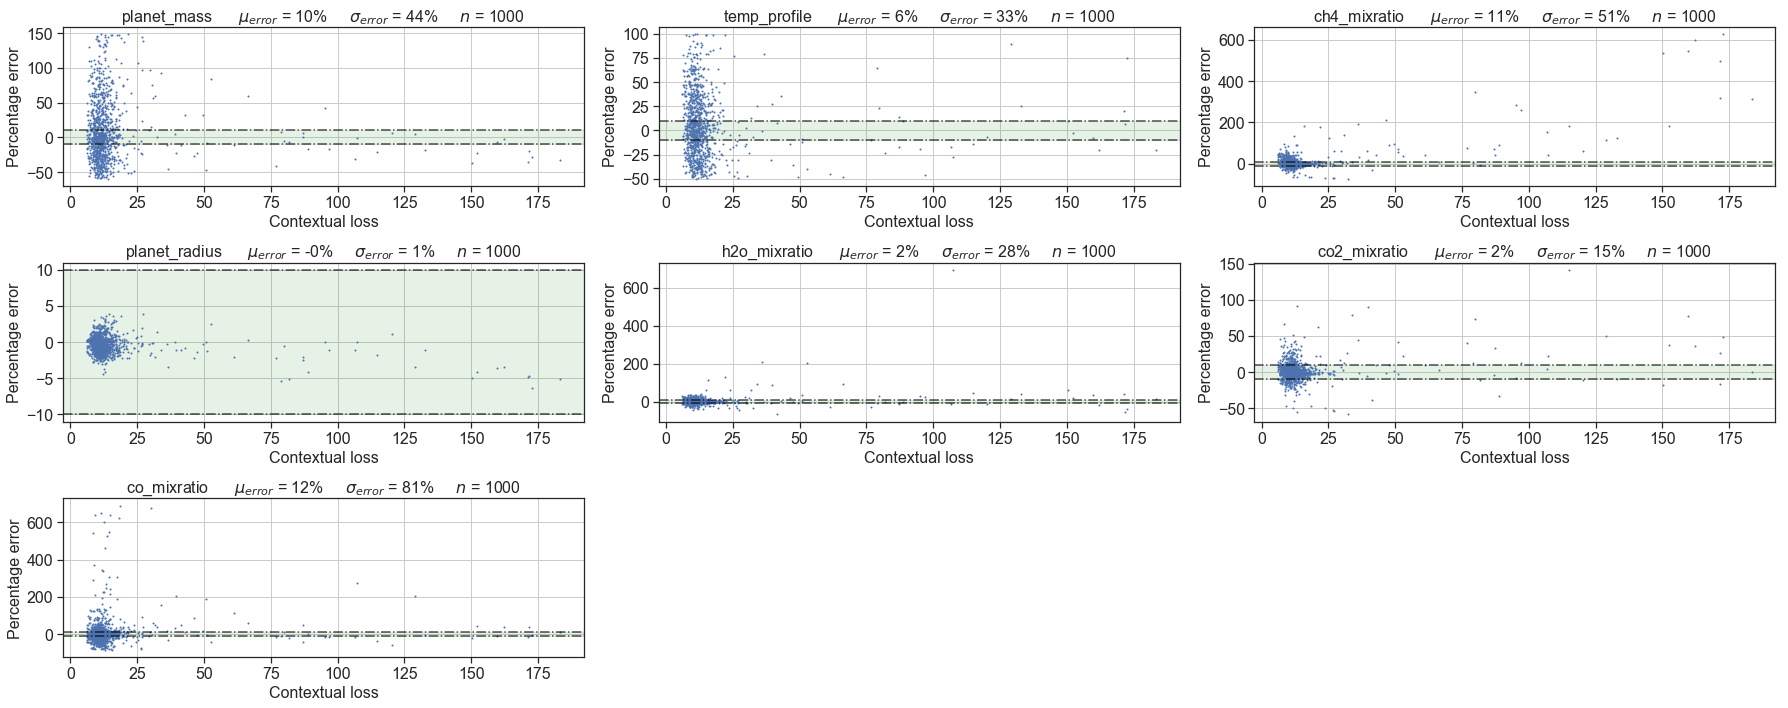

In [190]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.plot(df.contextuals, df[param+'_error'], '.', ms=2)
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    #plt.ylim((-100,100))
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Contextual loss', fontsize=fontsize)
    plt.ylabel(r'Percentage error', fontsize=fontsize)
    #plt.legend()
    plt.tight_layout()
    

# Param percentage errors vs perceptual loss
For perceptual loss, lower is better.

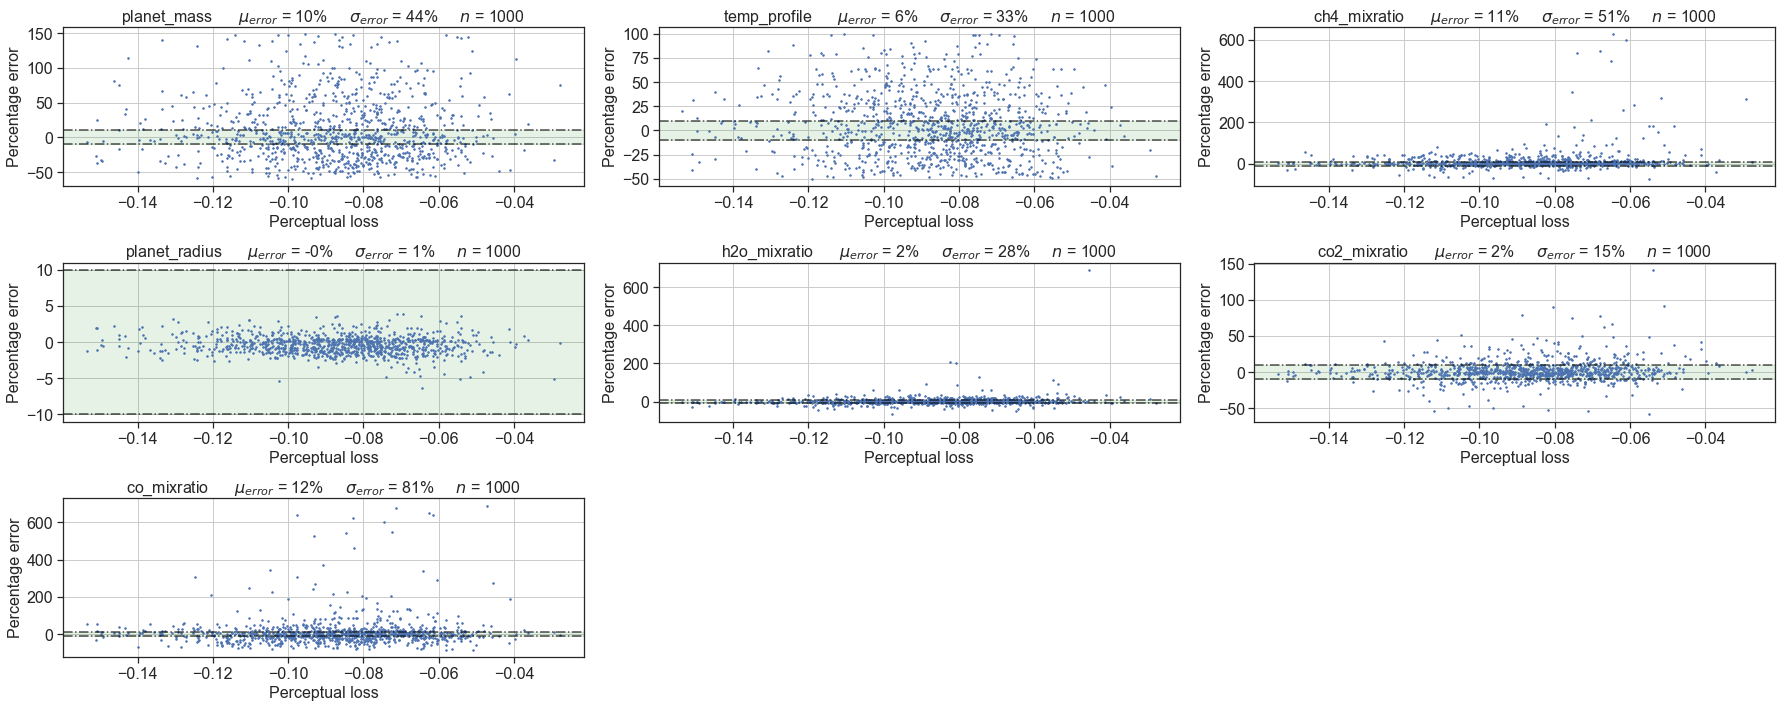

In [191]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.plot(df.perceptuals, df[param+'_error'], '.', ms=3)
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Perceptual loss', fontsize=fontsize)
    plt.ylabel(r'Percentage error', fontsize=fontsize)
    plt.tight_layout()